In [9]:
import os, sys, pathlib, glob
print("CWD =", os.getcwd())           # diretório em que o kernel está rodando
print("Existe CSV?", pathlib.Path("data").exists())   # deve dar False

CWD = /Users/felipefonseca/Library/Mobile Documents/com~apple~CloudDocs/Felipe/Files/Projects/Telegram Signal Collector/notebooks
Existe CSV? False


In [2]:
# Imports necessários
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Adicionar collector ao path
sys.path.append('../')
from collector import Config, Storage

# Configuração de gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("📊 Ambiente configurado!")


📊 Ambiente configurado!


In [10]:
# Configuração
config = Config()
storage = Storage(config)

# Escolher fonte de dados
USE_POSTGRES = False  # Altere para False para usar CSV
CSV_FILE = "../data/trading ops/June/29/daily ops/signals_2025-06-29.csv"  # Especifique o arquivo CSV se necessário

print(f"📊 Carregando dados de: {'PostgreSQL' if USE_POSTGRES else 'CSV'}")


📊 Carregando dados de: CSV


In [11]:
from pathlib import Path
print("Arquivo existe?", Path(CSV_FILE).exists())

Arquivo existe? True


In [12]:
# Carregar dados
if USE_POSTGRES:
    # Carregar do PostgreSQL (últimos 30 dias)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=30)
    
    signals = storage.load_from_postgres(start_date, end_date)
    print(f"📊 Carregados {len(signals)} sinais do PostgreSQL")
else:
    # Carregar do CSV
    signals = storage.load_from_csv(CSV_FILE)
    print(f"📊 Carregados {len(signals)} sinais do CSV")

if not signals:
    print("❌ Nenhum dado encontrado! Verifique a configuração.")
else:
    print(f"✅ Dados carregados: {len(signals)} sinais")
    print(f"📅 Período: {min(s.timestamp for s in signals)} até {max(s.timestamp for s in signals)}")


📊 Carregados 252 sinais do CSV
✅ Dados carregados: 252 sinais
📅 Período: 2025-06-29 06:02:06-03:00 até 2025-06-29 23:55:06-03:00


In [24]:
# Converter para DataFrame e calcular P&L
if signals:
    data = []
    for signal in signals:
        data.append({
            'timestamp': signal.timestamp,
            'date': signal.timestamp.date(),
            'hour': signal.timestamp.hour,
            'asset': signal.asset,
            'result': signal.result,
            'attempt': signal.attempt if signal.attempt else 0,
            'is_win': signal.result == 'W',
            'is_loss': signal.result == 'L'
        })
    
    df = pd.DataFrame(data)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    
    # Calcular P&L Martingale
    base_amount = 1  # R$ 10 por operação
    df['pnl'] = df['is_win'].apply(lambda x: base_amount if x else -7 * base_amount)
    df['pnl_cumulative'] = df['pnl'].cumsum()
    
    print(f"📊 DataFrame criado: {len(df)} registros")
    print(f"💰 P&L Total: R$ {df['pnl'].sum():,.2f}")
    print(f"📈 Win Rate: {df['is_win'].mean()*100:.1f}%")
    
    display(df.head())
else:
    print("❌ Sem dados para análise")


📊 DataFrame criado: 252 registros
💰 P&L Total: R$ -44.00
📈 Win Rate: 85.3%


,timestamp,date,hour,asset,result,attempt,is_win,is_loss,pnl,pnl_cumulative
0,2025-06-29 06:02:06-03:00,2025-06-29,6,SOL/USDT,W,1,True,False,1,1
1,2025-06-29 06:08:06-03:00,2025-06-29,6,XRP/USDT,L,0,False,True,-7,-6
2,2025-06-29 06:10:06-03:00,2025-06-29,6,XRP/USDT,W,1,True,False,1,-5
3,2025-06-29 06:20:06-03:00,2025-06-29,6,BTC/USDT,W,2,True,False,1,-4
4,2025-06-29 06:24:06-03:00,2025-06-29,6,XRP/USDT,W,1,True,False,1,-3


In [38]:
# Filtering ops after 20:00
df_20 = df[df['hour'] > 19]

# Zerando pnl acumulado do dia
df_20['pnl_cumulative'] -= df_20['pnl_cumulative'].iloc[0]

df_20.head()

,timestamp,date,hour,asset,result,attempt,is_win,is_loss,pnl,pnl_cumulative
193,2025-06-29 20:00:08-03:00,2025-06-29,20,ADA/USDT,W,1,True,False,1,0
194,2025-06-29 20:02:06-03:00,2025-06-29,20,XRP/USDT,W,1,True,False,1,1
195,2025-06-29 20:06:06-03:00,2025-06-29,20,XRP/USDT,W,1,True,False,1,2
196,2025-06-29 20:11:06-03:00,2025-06-29,20,ETH/USDT,W,1,True,False,1,3
197,2025-06-29 20:17:06-03:00,2025-06-29,20,ETH/USDT,L,0,False,True,-7,-4


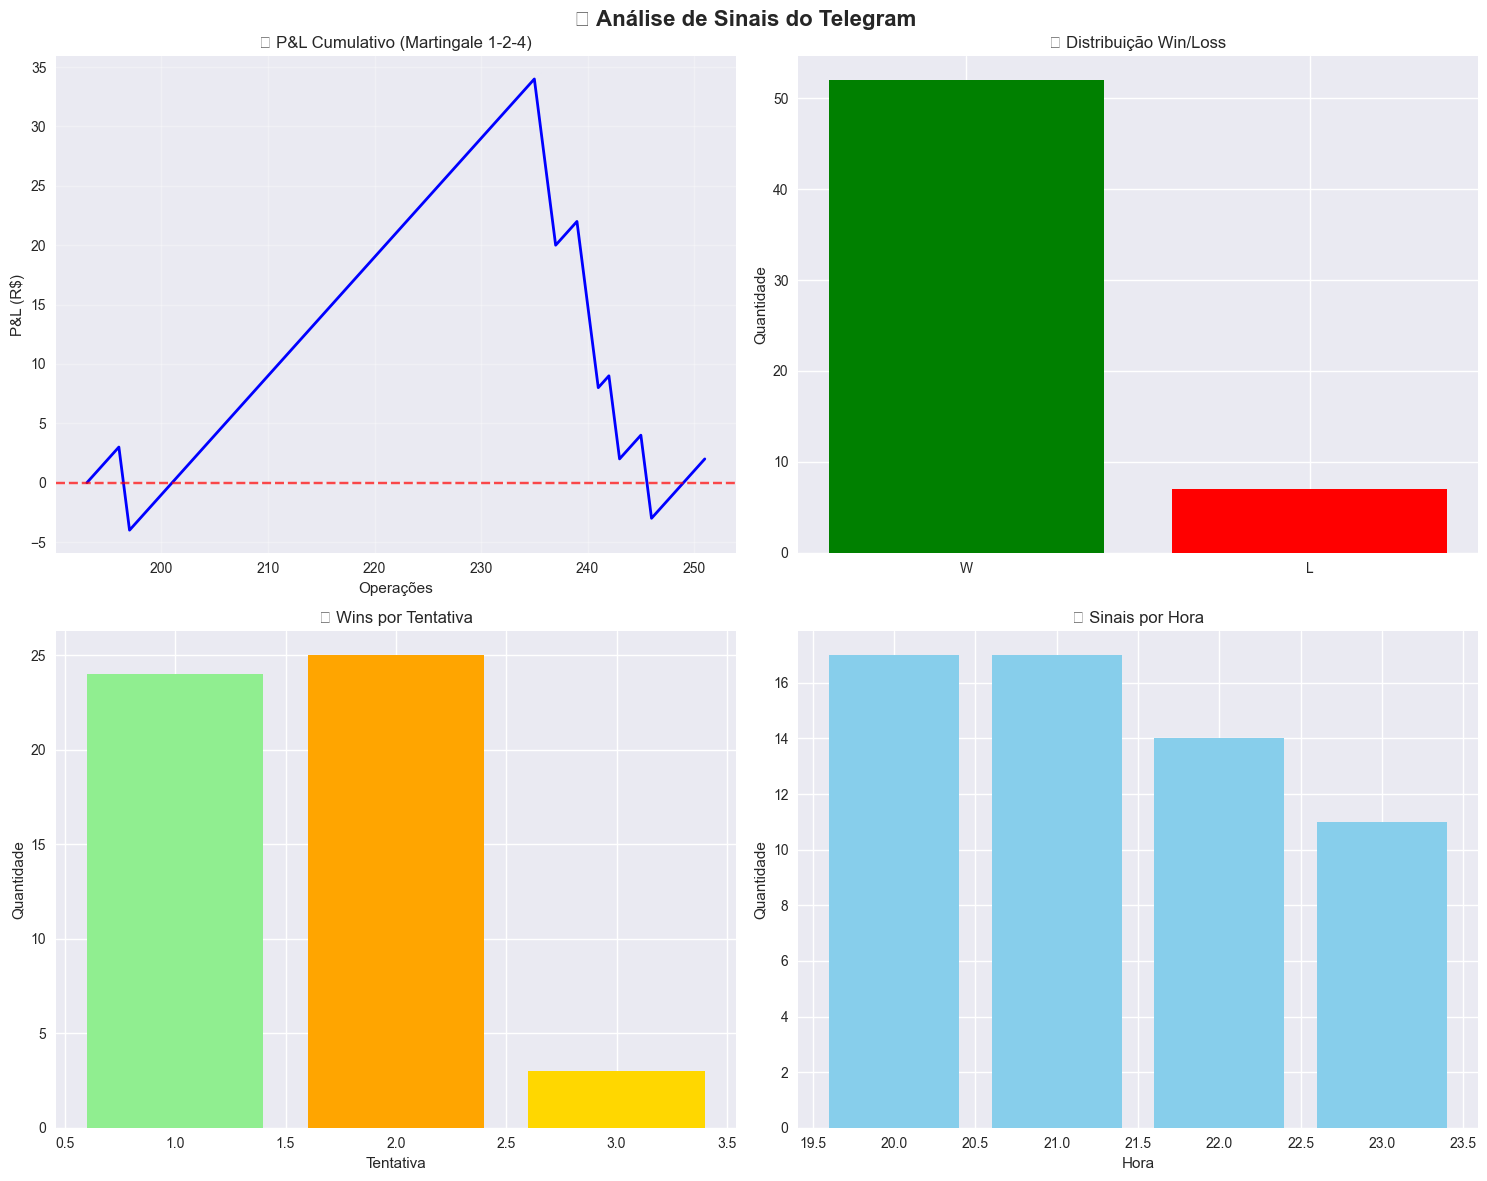

📊 ESTATÍSTICAS RESUMO
Total de operações: 59
Wins: 52 (88.1%)
Losses: 7 (11.9%)
P&L Final: R$ 2.00
Assets únicos: 5

🎯 ANÁLISE DE VIABILIDADE
Win rate atual: 88.1%
Win rate necessário: 89.4%
⚠️ Precisa melhorar 1.3% para ser lucrativo


In [35]:
if not df_20.empty:
    # Configurar figura
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('📊 Análise de Sinais do Telegram', fontsize=16, fontweight='bold')
    
    # 1. P&L Cumulativo
    axes[0, 0].plot(df_20.index, df_20['pnl_cumulative'], linewidth=2, color='blue')
    axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    axes[0, 0].set_title('💰 P&L Cumulativo (Martingale 1-2-4)')
    axes[0, 0].set_xlabel('Operações')
    axes[0, 0].set_ylabel('P&L (R$)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Distribuição de Resultados
    result_counts = df_20['result'].value_counts()
    colors = ['green' if x == 'W' else 'red' for x in result_counts.index]
    axes[0, 1].bar(result_counts.index, result_counts.values, color=colors)
    axes[0, 1].set_title('🎯 Distribuição Win/Loss')
    axes[0, 1].set_ylabel('Quantidade')
    
    # 3. Wins por Tentativa
    win_attempts = df_20[df_20['is_win']]['attempt'].value_counts().sort_index()
    if not win_attempts.empty:
        axes[1, 0].bar(win_attempts.index, win_attempts.values, 
                       color=['lightgreen', 'orange', 'gold'])
        axes[1, 0].set_title('🔥 Wins por Tentativa')
        axes[1, 0].set_xlabel('Tentativa')
        axes[1, 0].set_ylabel('Quantidade')
    
    # 4. Sinais por Hora
    hourly_signals = df_20['hour'].value_counts().sort_index()
    axes[1, 1].bar(hourly_signals.index, hourly_signals.values, color='skyblue')
    axes[1, 1].set_title('⏰ Sinais por Hora')
    axes[1, 1].set_xlabel('Hora')
    axes[1, 1].set_ylabel('Quantidade')
    
    plt.tight_layout()
    plt.show()
    
    # Estatísticas resumo
    print("📊 ESTATÍSTICAS RESUMO")
    print("=" * 40)
    print(f"Total de operações: {len(df_20)}")
    print(f"Wins: {df_20['is_win'].sum()} ({df_20['is_win'].mean()*100:.1f}%)")
    print(f"Losses: {df_20['is_loss'].sum()} ({df_20['is_loss'].mean()*100:.1f}%)")
    print(f"P&L Final: R$ {df_20['pnl_cumulative'].iloc[-1]:,.2f}")
    print(f"Assets únicos: {df_20['asset'].nunique()}")
    
    # Win rate necessário para breakeven (Martingale 1-2-4 com payout 90%)
    required_win_rate = 0.8942  # 89.42%
    current_win_rate = df_20['is_win'].mean()
    
    print(f"\n🎯 ANÁLISE DE VIABILIDADE")
    print(f"Win rate atual: {current_win_rate*100:.1f}%")
    print(f"Win rate necessário: {required_win_rate*100:.1f}%")
    
    if current_win_rate >= required_win_rate:
        print("✅ Sistema LUCRATIVO!")
    else:
        deficit = required_win_rate - current_win_rate
        print(f"⚠️ Precisa melhorar {deficit*100:.1f}% para ser lucrativo")
else:
    print("❌ Sem dados para visualizar")
